In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

## Problem 1: The SIR Model.

The SIR model is given by
$$\frac{\partial S}{\partial t} = - \beta S I$$
$$\frac{\partial I}{\partial t} = \beta S I - \gamma I$$
$$\frac{\partial R}{\partial t} = \gamma I$$

a.) I will solve this system using ODEint for these parameters and initial conditions:
$\beta = 0.3$, $\gamma = 0.1$, S(0) = 0.99, I(0) = 0.01, and R(0) = 0.

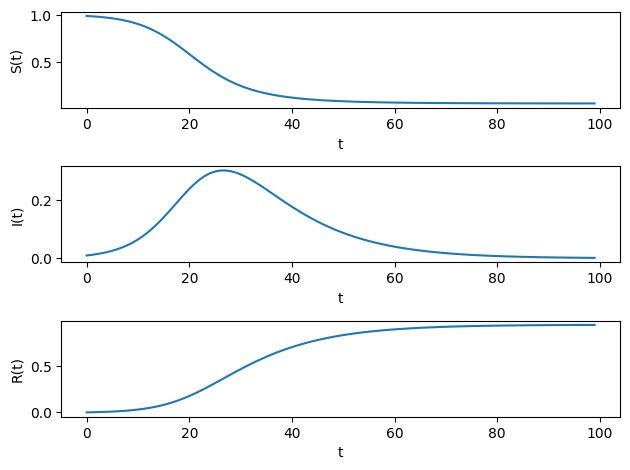

In [18]:
def SIR(X, t, gamma, beta):
    S,I,R = X
    dS = - beta *S*I
    dI = beta*S*I - gamma*I
    dR = gamma*I
    return dS, dI, dR

beta = 0.3
gamma = 0.1
t = np.arange(0, 100)
X0 = [0.99, 0.01, 0.0]

solution = odeint(SIR, X0, t, args=(gamma, beta))
S, I, R = solution.T


fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, S)
ax1.set_xlabel('t')
ax1.set_ylabel('S(t)')
ax2 = fig.add_subplot(312)
ax2.plot(t, I)
ax2.set_xlabel('t')
ax2.set_ylabel('I(t)')
ax3 = fig.add_subplot(313)
ax3.plot(t, R)
ax3.set_xlabel('t')
ax3.set_ylabel('R(t)')
plt.tight_layout()
plt.show()

The 3 solutions converge enventually to a steady state, hence if we plot their values at an advanced time, we would miss their evolution before convergence.<br>
Initially, the number of infected individuals increases reaching a maximum while the number of recovered individuals increases at a slower rate encoutring a inflection point as I reaches its maximum, and the number of susceptible individuals decreases at the same rate of the increase in R again reaching a inflection point as I reaches its maximum. S and I end up converging to 0, and R ends up converging to a steady positive value.

We will now apply Lasso regression to recover the parameters ($\beta, \gamma$) from the 3 time series (S, I, R).<br>
We introduce the feature vector to be a quadratic combination of S and I values, such that
$$\phi(S,I) = [S, I, S^2, I^2, SI]$$
And find the discrete derivatives of S,I and R (dS, dI, dR) with respect to time using the numpy gradient function, and use these values as our output.<br>
The parameter $\alpha$ is the constant that multiplies the L1 term to be minimized and it controls the minimization strength. I will be trying different magnitude scales for $\alpha$ to check which one returns a model closest to our theoretical picture.

In [19]:
phi = np.array([np.ones(len(S)), S, I, S**2, I**2, S*I]).T

dS = np.gradient(S,t)
dI = np.gradient(I,t)
dR = np.gradient(R,t)

dX = np.array([dS, dI, dR]).T
reg = Lasso(alpha = 1e-5)
fit = reg.fit(phi, dX)
coef = reg.coef_
print(coef)

[[ 0.         -0.00104825 -0.0043572   0.         -0.         -0.28204205]
 [ 0.          0.00182599 -0.08885621 -0.         -0.          0.2669403 ]
 [ 0.          0.          0.09887595  0.          0.          0.        ]]


I seems that for a VERY small magnitude of $\alpha$, $\approx$ $10^{-5}$, we get reasonable values for the fitting parameters.

The Lasso regression returned a model of the form
$$\dot S = -0.00104825 S -0.0043572 I -0.28204205 SI$$
$$\dot I = 0.00182599 S -0.08885621 I  + 0.2669403 SI$$
$$\dot R =0.09887595 I $$
(Which is so close to our theoretical model). I will find the square loss resulting from this model.

In [20]:
dS_Lasso = phi@coef[0]
dI_Lasso = phi@coef[1]
dR_Lasso = phi@coef[2]

Loss = [(dS - dS_Lasso)**2,(dI - dI_Lasso)**2, (dR - dR_Lasso)**2]
Loss = np.array(Loss)/len(dS)
print(np.mean(Loss))

2.7855452886856353e-09


The average loss of the 3 models is of the order of $10^{-9}$ which is not bad.

In [21]:
library_names = ['1', 'S', 'I', 'S^2', 'I^2', 'SI']
var_names = ['S', 'I'] 
for i in range(len(var_names)):
    eqn = [f'{var_names[i]}_dot = ']
    for j in range(coef.shape[1]):
        if coef[i, j] != 0:
            eqn.append(f'+ {coef[i, j]} {library_names[j]} ')
    print(''.join(eqn))

S_dot = + -0.001048250167409816 S + -0.004357199961510354 I + -0.2820420470452331 SI 
I_dot = + 0.001825987787907402 S + -0.08885620787602636 I + 0.2669403015552124 SI 


I will now define a function of the newly discovered model, solve it, and plot it so we could visualize the slight difference between the theoretical and Lasso models.

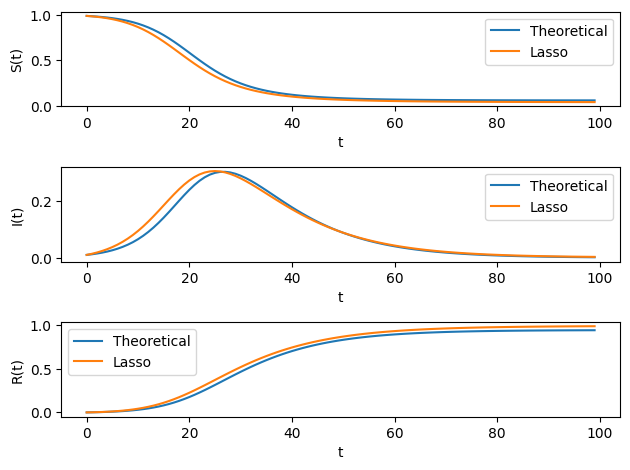

In [22]:
def SIR_Lasso(X, t, coef):
    S, I, R = X
    library = [1, S, I, S**2, I**2, S*I]
    dX_dt = []
    for i in range(3):
        eqn = 0
        for j in range(coef.shape[1]):
            if coef[i, j] != 0:
                eqn += coef[i, j] * library[j]
        dX_dt.append(eqn)
    return dX_dt

D0 = [0.99, 0.01, 0.0]
solution = odeint(SIR_Lasso, D0, t, args =(coef,))
S_Lasso, I_Lasso, R_Lasso = solution.T


fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, S, label = ('Theoretical'))
ax1.plot(t, S_Lasso, label=("Lasso"))
ax1.set_xlabel('t')
ax1.set_ylabel('S(t)')
ax1.legend()
ax2 = fig.add_subplot(312)
ax2.plot(t, I, label = ('Theoretical'))
ax2.plot(t, I_Lasso, label=("Lasso"))
ax2.set_xlabel('t')
ax2.set_ylabel('I(t)')
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.plot(t, R, label = ('Theoretical'))
ax3.plot(t, R_Lasso, label=("Lasso"))
ax3.set_xlabel('t')
ax3.set_ylabel('R(t)')
ax3.legend()
plt.tight_layout()
plt.show()